# ZFundPredictor (ver. 1.1) Demo
## Selection Criteria:
* <font size=3><I>Subject</I></font> — Open-end equity funds or hybrid funds with at least 75% of the investment in stocks.
* <font size=3><I>Investment Style</I></font> — mid-/large-cap growth stocks.
* <font size=3><I>Period</I></font> — lauched before 2015.
* <font size=3><I>Asset Size</I></font> — at least 200 million Yuan.

## Benchmark
* <font size=3><I>Equity</I></font> — SSE Composite Index (000001:SH)

In [1]:
import math
from datetime import datetime, timedelta, date
import re
import pymysql
import yfinance as yf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.multioutput import MultiOutputRegressor

## Getting data from MySQL

In [2]:
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='****',
                             db='funds',
                             charset='utf8mb4')
'''
CREATE VIEW picked AS
SELECT a.* FROM (
    SELECT fticker FROM histories
    WHERE hdate >= '2015-01-05'
    AND r_d != 0
    GROUP BY fticker
    HAVING COUNT(*) > 1150) f
JOIN (
    SELECT * FROM all_funds
    WHERE current_stocks >= 75
    AND current_net_assets > 2) a
ON a.fticker = f.fticker
WHERE current_bonds < 25 OR current_bonds IS NULL;
'''
sql = '''
SELECT h.fticker, h.hdate, accu_nav FROM histories h
RIGHT JOIN picked p
ON h.fticker = p.fticker
WHERE h.hdate >= '2015-01-05';
'''

funds_sql = pd.read_sql(sql, connection)
funds_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746487 entries, 0 to 746486
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   fticker   746487 non-null  object 
 1   hdate     746487 non-null  object 
 2   accu_nav  743938 non-null  float64
dtypes: float64(1), object(2)
memory usage: 17.1+ MB


In [3]:
sql = '''
SELECT
    fticker, ftype, current_style, current_net_assets,
    current_stocks, current_bonds, current_cash,
    industry_1, industry_1_pct, industry_2, industry_2_pct, industry_3, industry_3_pct,
    industry_4, industry_4_pct, industry_5, industry_5_pct, manager_ranking
FROM picked;
'''
# Short term invariant variables
st_invariants = pd.read_sql(sql, connection)

connection.close()

st_invariants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fticker             584 non-null    object 
 1   ftype               584 non-null    object 
 2   current_style       584 non-null    object 
 3   current_net_assets  584 non-null    float64
 4   current_stocks      584 non-null    float64
 5   current_bonds       357 non-null    float64
 6   current_cash        584 non-null    float64
 7   industry_1          556 non-null    object 
 8   industry_1_pct      556 non-null    float64
 9   industry_2          556 non-null    object 
 10  industry_2_pct      556 non-null    float64
 11  industry_3          556 non-null    object 
 12  industry_3_pct      556 non-null    float64
 13  industry_4          556 non-null    object 
 14  industry_4_pct      556 non-null    float64
 15  industry_5          556 non-null    object 
 16  industry

## Downloading data of index

In [4]:
def get_index(index_type='stock'):
    if index_type == 'stock':
        sindex = yf.download("000001.ss", start=str(funds_sql['hdate'].min()),
                             end=str(funds_sql['hdate'].max()+timedelta(days=1)))
        sindex.loc['2019-12-19'] = [3017.15,3021.42,3007.99,3017.07,3017.07,208600]
        sindex.loc['2019-04-29'] = [3090.63,3107.76,3050.03,3062.50,3062.50,292100]
        sindex.loc['2019-04-30'] = [3052.62,3088.41,3052.62,3078.34,3078.34,222300]
        sindex['sindex_r'] = (sindex['Adj Close'] - sindex['Adj Close'].shift(1)) / sindex['Adj Close'].shift(1)*100
        sindex['Date'] = sindex.index
        sindex = sindex.set_index(pd.to_datetime(sindex['Date']).dt.date).drop(columns='Date').sort_index()
        return sindex
    
    if index_type == 'bond':
        tbond = pd.read_csv(r'China 10-Year Bond Yield Historical Data.csv')
        tbond = tbond.set_index(pd.to_datetime(tbond['Date']).dt.date).sort_index()
        tbond['tbond_d'] = tbond['Change %'].str.rstrip('%').astype('float') / 100.0
        tbond.drop(columns=['Date', 'Change %'], inplace=True)
        return tbond
    
sindex = get_index()
sindex

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,sindex_r
Date,,,,,,,
2015-01-05,3258.626953,3369.281006,3253.883057,3350.519043,3350.519043,531400.0,NaN
2015-01-06,3330.799072,3394.224121,3303.184082,3351.446045,3351.446045,501700.0,0.027667
2015-01-07,3326.648926,3374.895996,3312.210938,3373.954102,3373.954102,391900.0,0.671592
2015-01-08,3371.957031,3381.565918,3285.094971,3293.456055,3293.456055,371100.0,-2.385867
2015-01-09,3276.965088,3404.833984,3267.509033,3285.412109,3285.412109,410200.0,-0.244240
...,...,...,...,...,...,...,...
2020-03-30,2739.718994,2759.099121,2723.053955,2747.214111,2747.214111,239700.0,-0.901405
2020-03-31,2767.306885,2771.167969,2743.114990,2750.295898,2750.295898,218600.0,0.112179
2020-04-01,2743.541016,2773.364014,2731.079102,2734.521973,2734.521973,217300.0,-0.573536


## EDA - Preprocessing

Number of funds with missing values in *Historical Prices*: 4
Number of funds with missing values in *Short-Term Invariant Variables*: 28
Total number of funds to be dropped because of missing data: 32


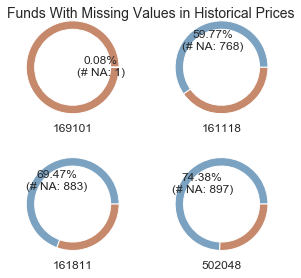

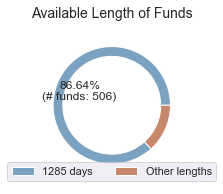

selected_tickers[0]: 000001
Number of tickers: 483


In [5]:
def find_missing_values(show_results):
    drop_tickers = funds_sql[funds_sql['accu_nav'].isnull()]['fticker'].unique()
    
    if show_results:
        n_col = math.ceil(len(drop_tickers)/2)

        fig = plt.figure(figsize=(2*n_col,4))
        fig.suptitle('Funds With Missing Values in Historical Prices', fontsize=14)
        for i, ticker in enumerate(drop_tickers):
            _null = funds_sql[funds_sql['fticker'] == ticker]['accu_nav'].isnull().sum()
            _notnull = funds_sql[funds_sql['fticker'] == ticker]['accu_nav'].notnull().sum()

            ax = fig.add_subplot(2, n_col, i+1)
            fig.tight_layout()        
            ax.pie([_null, _notnull], radius=1.1, wedgeprops=dict(width=0.2),
                   colors=sns.color_palette('twilight_shifted', n_colors=2),
                   autopct=lambda pct: '{:.2f}%\n(# NA: {:.0f})'.format(pct, _null) 
                            if int(pct) == int(_null/(_notnull+_null)*100) else '')
            plt.xlabel(ticker)
        
        print('Number of funds with missing values in *Historical Prices*:', len(drop_tickers))
        drop_tickers2 = st_invariants[(st_invariants['industry_1'].isnull()) | 
                                     (st_invariants['manager_ranking'].isnull())]['fticker']
        print('Number of funds with missing values in *Short-Term Invariant Variables*:', len(drop_tickers2))
        drop_tickers = set(drop_tickers) | set(drop_tickers2)
        print('Total number of funds to be dropped because of missing data:', len(drop_tickers))
        plt.show()
    
    return drop_tickers

def count_days(show_results):
    funds_length = funds_sql.groupby('fticker')['hdate'].count()
    count_per_length = funds_length.groupby(funds_length.values).count()
    
    max_count = count_per_length.max()
    rest = count_per_length.sum() - max_count
    most_common_length = count_per_length[count_per_length == max_count].index[0]
    
    tickers_common_length = funds_length[funds_length == most_common_length].index
    
    if show_results:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.pie([max_count, rest], wedgeprops=dict(width=0.15), radius=0.9,
               colors=sns.color_palette('twilight_shifted', n_colors=2),
               autopct=lambda pct: '{:.2f}%\n(# funds: {})'.format(pct, max_count) if pct>50 else '')
        plt.title('Available Length of Funds', fontsize=14)
        plt.legend([str(most_common_length)+' days', 'Other lengths'], loc='lower center', ncol=2)
        plt.show()
    return tickers_common_length

def ticker_filter(show_results=True):
    drop_tickers = find_missing_values(show_results)
    tickers_common_length = count_days(show_results)
    return np.array([t for t in tickers_common_length if t not in drop_tickers])

selected_tickers = ticker_filter()
print('selected_tickers[0]:', selected_tickers[0])
print('Number of tickers:', len(selected_tickers))

In [6]:
def get_funds(selected_tickers, stock_index, bond_index=None, show_results=True):
    for ticker, histories in funds_sql.groupby('fticker'):
        if ticker in selected_tickers:
            if ticker == selected_tickers[0]:
                funds = pd.DataFrame(index=histories['hdate'])
            funds[ticker] = histories['accu_nav'].values
        
    fund_std = funds.apply(lambda x: x.std())
    cutoff = 0.75
    highly_volatile = fund_std[fund_std > cutoff]
    
    if show_results:
        fig, ax = plt.subplots(figsize=(10, 1.5))
        sns.boxplot(data=fund_std, orient='h', color='mediumslateblue', width=0.3, ax=ax)
        ax.vlines(cutoff, -0.5, 0.5, linestyles='dashed', colors='orange')

        for order, sorting_idx in enumerate(highly_volatile.argsort()[::-1]):
            stv = highly_volatile[sorting_idx]
            stv_ticker = fund_std[fund_std == stv].index[0]
            arrowprops = {'arrowstyle':'simple,head_length=0.8,head_width=0.6,tail_width=0.3',
                          'ec':None, 'facecolor':'orange', 'connectionstyle':'arc3',
                          'shrinkA':0, 'shrinkB':5}
            if order%4 == 0:
                ax.text(stv-0.06, -0.1, stv_ticker)
            elif order%4 == 2:
                plt.annotate(stv_ticker, xy=(stv, 0), xytext=(stv-0.01, -0.3), arrowprops=arrowprops)
            elif order%4 == 1:
                ax.text(stv-0.06, 0.2, stv_ticker)
            else:
                plt.annotate(stv_ticker, xy=(stv, 0), xytext=(stv-0.04, 0.4), arrowprops=arrowprops)
        plt.yticks([0], ['STDEV'])
        plt.title('Volatility of Funds', fontsize=14)
        plt.show()
    

    new_cols = [c for c in funds.columns if c not in highly_volatile.index]
    funds = funds.loc[:, new_cols]
    
    if bond_index:
        funds_ = pd.concat([funds, stock_index, bond_index], axis=1, join='inner').dropna()
    else:
        funds_ = pd.concat([funds, stock_index], axis=1, join='inner').dropna()
    funds_.index.rename('Date', inplace=True)

    
    if show_results:
        print('Removing funds with excessive volatility:', [c for c in highly_volatile.index])
        print('Dates further dropped:', [str(i) for i in funds.index if i not in funds_.index])
        print('Final available funds:', funds.shape[1])
        print('Final available days:', funds_.shape[0])
        
    return funds_

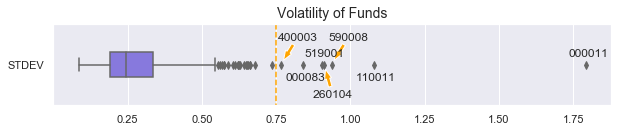

Removing funds with excessive volatility: ['000011', '000083', '110011', '260104', '400003', '519001', '590008']
Dates further dropped: ['2015-01-05', '2016-12-31', '2017-12-31', '2018-06-30', '2018-12-31', '2019-06-30']
Final available funds: 476
Final available days: 1279


,000001,000020,000021,000029,000031,000039,000042,000059,000061,000063,...,660015,688888,690001,690005,690007,700001,710001,710002,762001,sindex_r
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,3.546,2.836,2.987,2.521,2.049,2.2363,1.7512,1.5907,0.764,1.593,...,3.5073,1.475,2.343,2.212,3.111,1.595,2.2685,2.7586,2.6872,-0.901405
2020-03-31,3.548,2.856,2.986,2.514,2.054,2.2495,1.7516,1.5963,0.760,1.591,...,3.5266,1.478,2.385,2.227,3.132,1.611,2.2836,2.7649,2.6928,0.112179
2020-04-01,3.548,2.848,2.992,2.506,2.064,2.2305,1.7456,1.5817,0.763,1.586,...,3.5101,1.478,2.373,2.222,3.109,1.595,2.2550,2.7570,2.6842,-0.573536
2020-04-02,3.564,2.892,3.049,2.517,2.135,2.2842,1.7608,1.5934,0.778,1.620,...,3.6034,1.496,2.395,2.240,3.150,1.604,2.3018,2.8169,2.7003,1.686436
2020-04-03,3.559,2.884,3.040,2.519,2.120,2.2661,1.7541,1.6041,0.774,1.608,...,3.5857,1.481,2.395,2.247,3.145,1.605,2.3031,2.8077,2.7006,-0.598815


In [7]:
funds = get_funds(selected_tickers, sindex['sindex_r'], show_results=True)
funds.tail()

In [8]:
def build_categories(funds):
    categorical = pd.DataFrame(index=st_invariants['fticker'])
    
    # label categories
    categorical['fund_type'] = st_invariants['ftype'].astype('category').values
    categorical['fund_style'] = st_invariants['current_style'].astype('category').values
    
    # numerical to categorical
    categorical['asset_size'] = pd.qcut(st_invariants['current_net_assets'].values, 4)
    categorical['ranking_score'] = pd.cut(st_invariants['manager_ranking'].values, [0,0.25,0.5,0.75,1])
    
    for col in ['current_stocks', 'current_bonds', 'current_cash']:
        categorical[col] = (st_invariants[col]/100).fillna(0).values
    
    # one-hot encoding for industries 
    weighted_oh = []
    for x in range(1,6):
        _oh = pd.get_dummies(st_invariants['industry_%s'%x].values)
        for ind in range(_oh.shape[1]):
            _oh.iloc[:,ind] = _oh.iloc[:,ind]*st_invariants['industry_%s_pct'%x].values/100
        weighted_oh.append(_oh)
    
    industry_w = pd.DataFrame(index=st_invariants['fticker'], columns=industries).applymap(lambda x: 0)
    
    columns = []
    for num, indust in enumerate(industries):
        for x in range(1,6):
            if indust in set(st_invariants['industry_%s'%x]):
                industry_w[indust] = industry_w[indust].values + weighted_oh[x-1][indust].values
        columns.append('ind_%s'%num) 
    industry_w.columns = columns
    
    # conbine all
    categorical = pd.concat([categorical, industry_w], axis=1)
    tickers_ = [t for t in funds.columns if t not in ['sindex_r', 'tbond_d']]
        
    return categorical.loc[tickers_]

industries = ['制造业', '金融业', '信息传输、软件和信息技术服务业', '房地产业',
              '交通运输、仓储和邮政业', '农、林、牧、渔业', '批发和零售业',
              '采矿业', '住宿和餐饮业', '租赁和商务服务业', '水利、环境和公共设施管理业',
              '文化、体育和娱乐业', '科学研究和技术服务业', '卫生和社会工作', '建筑业',
              '电力、热力、燃气及水生产和供应业', '教育', '综合']

categorical = build_categories(funds)
categorical

,fund_type,fund_style,asset_size,ranking_score,current_stocks,current_bonds,current_cash,ind_0,ind_1,ind_2,...,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
fticker,,,,,,,,,,,,,,,,,,,,,
000001,混合型,大盘价值,"(20.035, 205.29]","(0.0, 0.25]",0.7564,0.2016,0.0172,0.4409,0.0564,0.0621,...,0.0,0.0336,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
000020,混合型,大盘价值,"(4.742, 9.575]","(0.75, 1.0]",0.8240,0.0000,0.1937,0.5197,0.0000,0.0780,...,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
000021,混合型,大盘平衡,"(20.035, 205.29]","(0.0, 0.25]",0.9316,0.0253,0.0366,0.6286,0.1470,0.1045,...,0.0,0.0043,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
000029,混合型,大盘价值,"(2.009, 4.742]","(0.75, 1.0]",0.8355,0.0276,0.0377,0.4530,0.1507,0.1447,...,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
000031,混合型,大盘平衡,"(9.575, 20.035]","(0.75, 1.0]",0.9199,0.0483,0.0344,0.7309,0.0000,0.0723,...,0.0,0.0675,0.0,0.0281,0.0197,0.0000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690007,混合型,大盘价值,"(9.575, 20.035]","(0.75, 1.0]",0.8346,0.0000,0.1773,0.6545,0.0560,0.0146,...,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
700001,混合型,大盘价值,"(2.009, 4.742]","(0.5, 0.75]",0.9023,0.0507,0.0596,0.6551,0.0919,0.0309,...,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
710001,混合型,大盘价值,"(9.575, 20.035]","(0.5, 0.75]",0.9396,0.0435,0.0223,0.7290,0.1022,0.0676,...,0.0,0.0000,0.0,0.0053,0.0000,0.0000,0.0,0.0,0.0,0.0


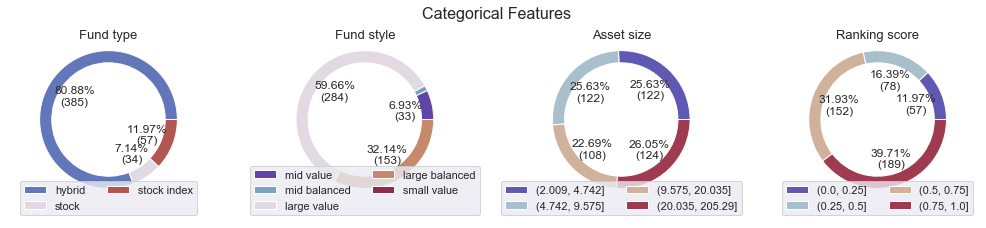

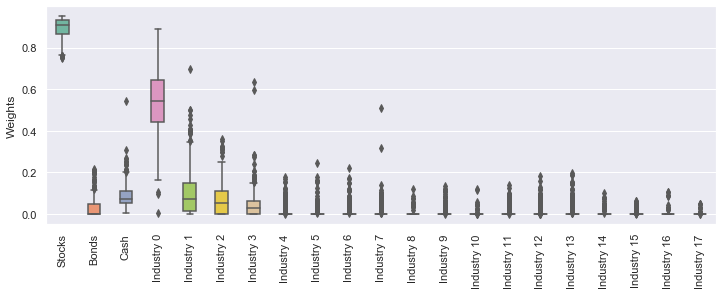

,ind_0,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14,ind_15,ind_16,ind_17
行业,制造业,金融业,信息传输、软件和信息技术服务业,房地产业,交通运输、仓储和邮政业,农、林、牧、渔业,批发和零售业,采矿业,住宿和餐饮业,租赁和商务服务业,水利、环境和公共设施管理业,文化、体育和娱乐业,科学研究和技术服务业,卫生和社会工作,建筑业,电力、热力、燃气及水生产和供应业,教育,综合
Industry,Manufacturing,Finance,"Information Transmission, Software & Informati...",Real Estate,"Transportation, Warehousing & Postal Services","Agriculture, Forestry, Animal Husbandry & Fishery",Wholesale & Retail Trade,Mining,Hospitality & Catering,Lease & Business Services,"Water Conservancy, Environment & Public Facili...","Culture, Sports & Entertainment",Scientific Research & Technical Services,Health & Social Work,Construction,"Power, Heat, Gas & Water Production and Supply",Education,Comprehensive
mean,0.5401,0.1044,0.0698,0.0417,0.0123,0.0064,0.0099,0.0108,0.0019,0.0076,0.0012,0.0089,0.011,0.0134,0.0027,0.0019,0.0014,0.0006
std,0.137,0.1132,0.0719,0.0621,0.0276,0.0246,0.0268,0.0338,0.0109,0.0207,0.0092,0.0215,0.0246,0.0311,0.011,0.0085,0.0102,0.0046
min,0.0052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,0.4422,0.0152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,0.5449,0.0704,0.0519,0.0299,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75%,0.6462,0.1477,0.108,0.0609,0,0,0,0,0,0,0,0,0,0,0,0,0,0
max,0.8896,0.6951,0.3602,0.634,0.1769,0.2439,0.2185,0.5071,0.1194,0.1341,0.1206,0.1414,0.1806,0.1956,0.1023,0.0642,0.1071,0.0486


In [9]:
def categorical_summary(categorical):
    dicts = [{'混合型':'hybrid', '股票型':'stock', '股票指数':'stock index'},
             {'大盘价值':'large value', '大盘平衡':'large balanced', '中盘成长':'large growth',
              '中盘价值':'mid value', '中盘平衡':'mid balanced', '中盘成长':'mid growth',
              '小盘价值':'small value', '小盘平衡':'small balanced', '小盘成长':'small growth'}]
    groups = ['fund_type', 'fund_style', 'asset_size', 'ranking_score']
    industry_w = categorical.iloc[:,-len(industries):]
    allocation = categorical.loc[:,['current_stocks','current_bonds','current_cash']]
    
    fig = plt.figure(figsize=(14,3.5))
    cmap = plt.get_cmap('tab20b')
    fig.suptitle('Categorical Features', fontsize=16)
    
    for i,feat in enumerate(groups):
        ax = fig.add_subplot(1,4,i+1)
        fig.tight_layout()
        
        grouped = categorical[groups].groupby(feat)[feat]
        ax.pie(grouped.count(), radius=0.85, wedgeprops=dict(width=0.15),
               colors=sns.color_palette('twilight_shifted', n_colors=len(grouped)),
               autopct=lambda pct: 
                       '{:.2f}%\n({:.0f})'.format(pct, categorical.shape[0]*pct/100)
                       if pct>5 else '')
        
        legend_param = {'loc':'lower center', 'ncol':2}
        if i in [0, 1]:
            plt.legend([dicts[i][idx] for idx, group in grouped], **legend_param)
        else:
            plt.legend([idx for idx, group in grouped], **legend_param)
        plt.title(re.sub('_',' ', feat).capitalize(), fontsize=13, pad=-20)
    
    fig, ax1 = plt.subplots(figsize=(12,4))
    sns.boxplot(data=pd.concat((allocation, industry_w), axis=1), ax=ax1, width=0.4,
                palette=sns.color_palette('Set2', n_colors=len(industry_w.columns)+3))
    plt.xticks(range(len(industry_w.columns)+3),
               ['Stocks', 'Bonds', 'Cash']+['Industry '+col.strip('ind_') for col in industry_w.columns], rotation=90)
    plt.ylabel('Weights')
    plt.show()
    
    industry_dict = {'住宿和餐饮业':'Hospitality & Catering',
     '租赁和商务服务业':'Lease & Business Services',
     '水利、环境和公共设施管理业':'Water Conservancy, Environment & Public Facilities Management',
     '金融业':'Finance',
     '文化、体育和娱乐业':'Culture, Sports & Entertainment',
     '房地产业':'Real Estate',
     '科学研究和技术服务业':'Scientific Research & Technical Services',
     '交通运输、仓储和邮政业':'Transportation, Warehousing & Postal Services',
     '批发和零售业':'Wholesale & Retail Trade',
     '卫生和社会工作':'Health & Social Work',
     '农、林、牧、渔业':'Agriculture, Forestry, Animal Husbandry & Fishery',
     '综合':'Comprehensive',
     '电力、热力、燃气及水生产和供应业':'Power, Heat, Gas & Water Production and Supply',
     '建筑业':'Construction',
     '制造业':'Manufacturing',
     '采矿业':'Mining',
     '信息传输、软件和信息技术服务业':'Information Transmission, Software & Information Technology Services',
     '教育':'Education'}
    
    industries_ = industries + [industry_dict[ind] for ind in industries]
    industries_ = pd.DataFrame(np.array(industries_).reshape(2,-1), columns=industry_w.columns, index=['行业','Industry'])
    summary = industry_w.describe()[1:].applymap(lambda x: round(x,4))
    summary = pd.concat((industries_, summary),axis=0)
    return summary

industry_summary = categorical_summary(categorical)
industry_summary

## FundPredictor

In [10]:
tickers = [t for t in funds.columns if t not in ['sindex_r', 'tbond_d']]
randt = tickers[np.random.randint(len(tickers), size=1)[0]]

In [11]:
import os
os.chdir('./ZFundPredictor')

from ZFundPredictor import FundPredictor

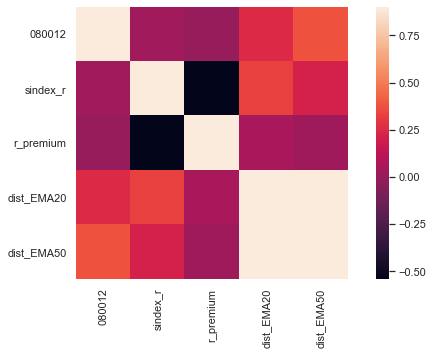

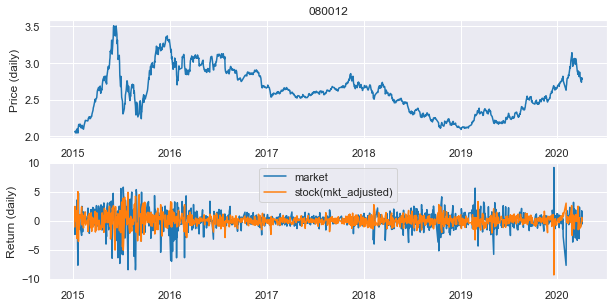

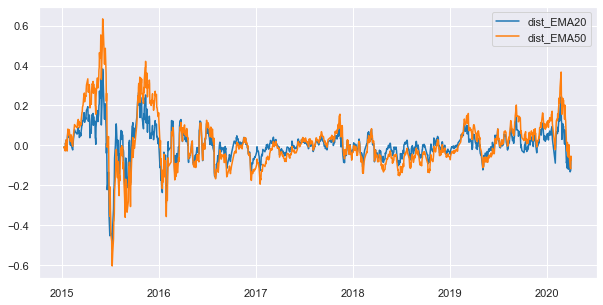

In [16]:
predictor = FundPredictor(funds)
predictor.draw_histories(randt, ema=[20,50])

In [18]:
categorical.loc[randt]

fund_type                     混合型
fund_style                   大盘平衡
asset_size        (9.575, 20.035]
ranking_score         (0.75, 1.0]
current_stocks             0.7685
current_bonds                   0
current_cash               0.2644
ind_0                       0.542
ind_1                      0.0481
ind_2                      0.1289
ind_3                           0
ind_4                           0
ind_5                           0
ind_6                           0
ind_7                           0
ind_8                           0
ind_9                      0.0224
ind_10                          0
ind_11                     0.0273
ind_12                          0
ind_13                          0
ind_14                          0
ind_15                          0
ind_16                          0
ind_17                          0
Name: 080012, dtype: object

_________________
<font size=3>It is interesting to discover that the market-adjusted return of this fund are inversely correlated to the return of index, although it is classified as a large-cap balanced hybrid fund. No wander it has been among the lowest in terms of manager ranking score, given the previous market spikes.<br>
Nevertheless, it might not be such a bad thing since the bull market is quite over now...</font>
_________________

=============== 080012: Model (50, 1) ===============
Train Size: (982, 50, 5) (246, 50, 5)
Test Size: (982, 1) (246, 1)
Size of Data for Future Prediction: (1, 50, 5)
Stopped at epoch: 18
Train Score: 0.00090 MSE (0.03 RMSE)
Test Score: 0.00039 MSE (0.02 RMSE)
R-Squared: 0.9579
Future Prediction: [2.701]
=============== 080012: Model (120, 2) ===============
Train Size: (926, 120, 5) (231, 120, 5)
Test Size: (926, 2) (231, 2)
Size of Data for Future Prediction: (1, 120, 5)
Stopped at epoch: 18
Train Score: 0.00115 MSE (0.03 RMSE)
Test Score: 0.00060 MSE (0.02 RMSE)
R-Squared: 0.9378
Future Prediction: [2.721, 2.7048]
=============== 080012: Model (120, 5) ===============
Train Size: (923, 120, 5) (231, 120, 5)
Test Size: (923, 5) (231, 5)
Size of Data for Future Prediction: (1, 120, 5)
Stopped at epoch: 16
Train Score: 0.00187 MSE (0.04 RMSE)
Test Score: 0.00118 MSE (0.03 RMSE)
R-Squared: 0.8776
Future Prediction: [2.7422, 2.7336, 2.6427, 2.654, 2.7038]


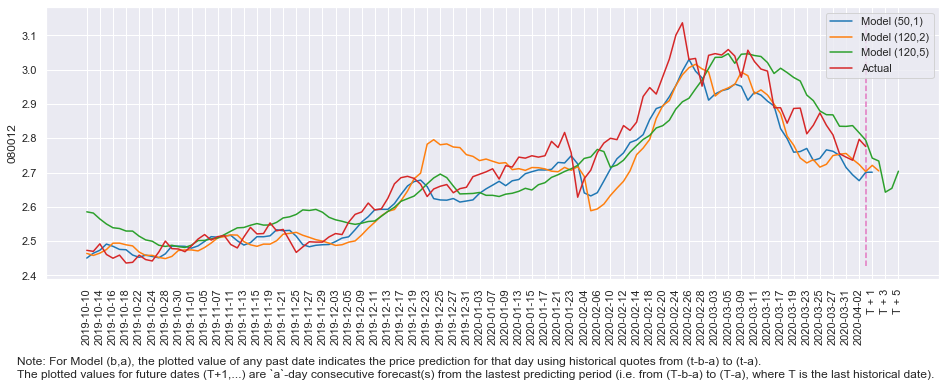

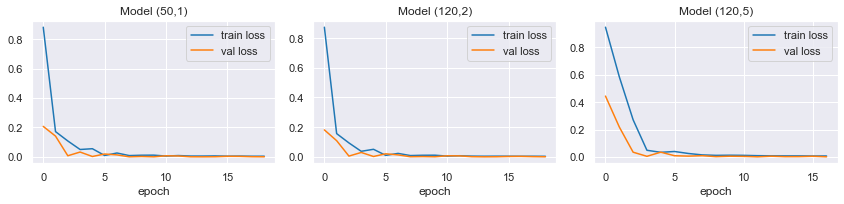

In [12]:
callbacks = [keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-5, patience=5)]

params = {'ema':[20, 50],
          'epochs':90, 'batches':300, 'lr':0.0005,
          'windows':[[50, 1], [120, 2], [120, 5]],
          'callbacks':callbacks,
          'show_history':True}

single_prediction = predictor.get_prediction(randt, **params)

=============== 080012: Model (50, 1) ===============
Train Size: (982, 50, 5) (246, 50, 5)
Test Size: (982, 1) (246, 1)
Size of Data for Future Prediction: (1, 50, 5)
Selected Hyperparameters: [{'ema': [5, 50], 'dropout': 0.2}, {'ema': [20, 50], 'dropout': 0.3}, {'ema': None, 'dropout': 0.3}]
R-Squared (ensemble): 0.9529
Future Prediction: [2.6801]
=============== 080012: Model (120, 2) ===============
Train Size: (926, 120, 5) (231, 120, 5)
Test Size: (926, 2) (231, 2)
Size of Data for Future Prediction: (1, 120, 5)
Selected Hyperparameters: [{'ema': [5, 50], 'dropout': 0.3}, {'ema': [20, 50], 'dropout': 0.3}, {'ema': None, 'dropout': 0.3}]
R-Squared (ensemble): 0.9264
Future Prediction: [2.6348, 2.6763]
=============== 080012: Model (120, 5) ===============
Train Size: (923, 120, 5) (231, 120, 5)
Test Size: (923, 5) (231, 5)
Size of Data for Future Prediction: (1, 120, 5)
Selected Hyperparameters: [{'ema': None, 'dropout': 0.3}, {'ema': [20, 50], 'dropout': 0.3}]
R-Squared (ensemble

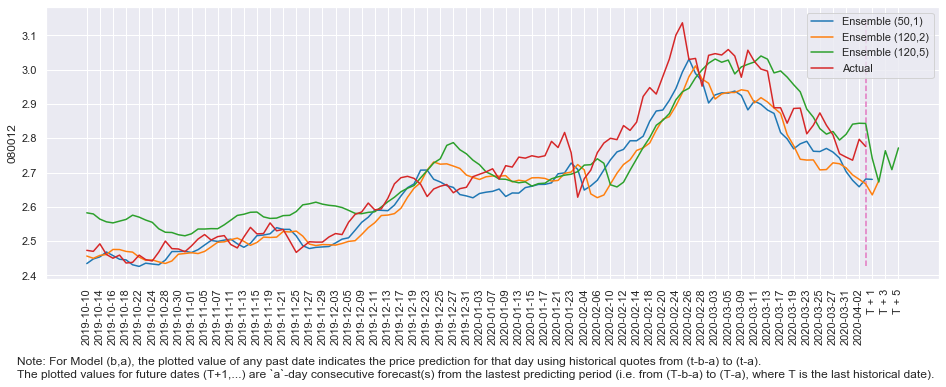

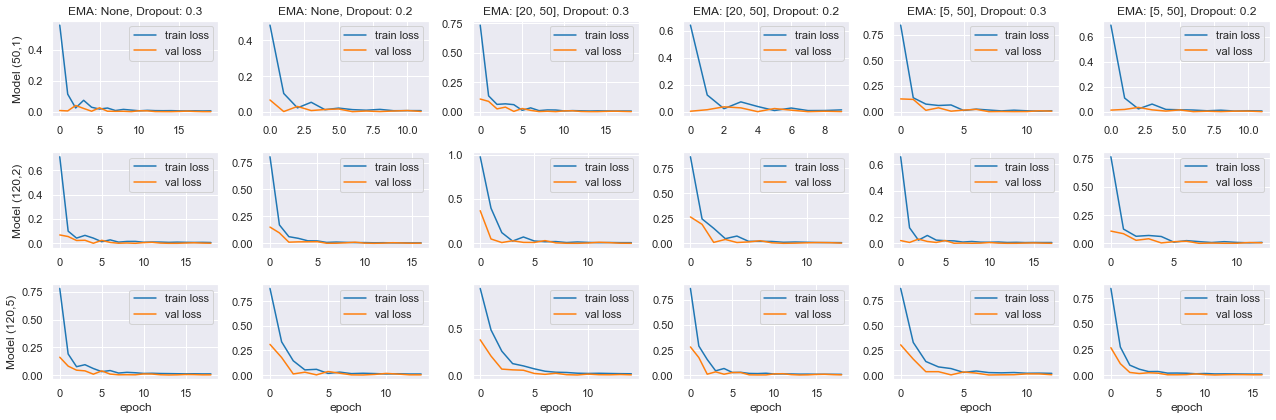

In [13]:
predictor = FundPredictor(funds)

tune_params = {'ema_basket':[None, [20,50], [5,50]],
               'dropout_basket':[0.3, 0.2],
               'show_history':True,
               'pred_params':{'epochs':90, 'batches':300, 'lr':0.0005, 
                              'callbacks':callbacks,
                              'windows':[[50, 1], [120, 2], [120, 5]]}}

ensemble_prediction = predictor.ensemble_prediction(randt, **tune_params)

_________________
<font size=3>It seems that for this particular fund, ***{'ema': [20, 50], 'dropout': 0.3}*** represents the best-performing hyperparameter combination. However, for numerous other funds, prediction accuracy may vary with different hyperparameter choices.</font>
_________________